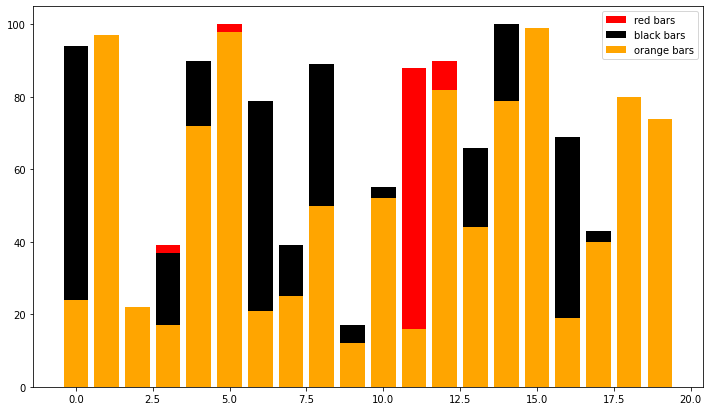

In [1]:
from scripts import parse_log as pl
from scripts import plot_data as dplt
import matplotlib.pyplot as plt
import matplotlib
import random as r
def createXYdata():
    data = [(i, r.randint(0, 100)) for i in range(20)]
    x = [d[0] for d in data]
    y = [d[1] for d in data]
    return [x, y]
def plot_bar(x, y, ax, color, label):
    ax.bar(x, y, color = color, label = label)
    
fig, ax = plt.subplots()
x,y = createXYdata()
plot_bar(x, y, ax, "r", "red bars")
x,y = createXYdata()
plot_bar(x, y, ax, "k", "black bars")
x,y = createXYdata()
plot_bar(x, y, ax, "orange", "orange bars")



plt.legend()
plt.show()

In [6]:
from scripts import updated_plot_data as uplt
import matplotlib.pyplot as plt
import random as r
from scripts import updated_parse_data as upl
# Overhead : For development only.
%load_ext autoreload
%autoreload 2



### Create bar plots comparing the runtime of [1...n] logs for any n > 0

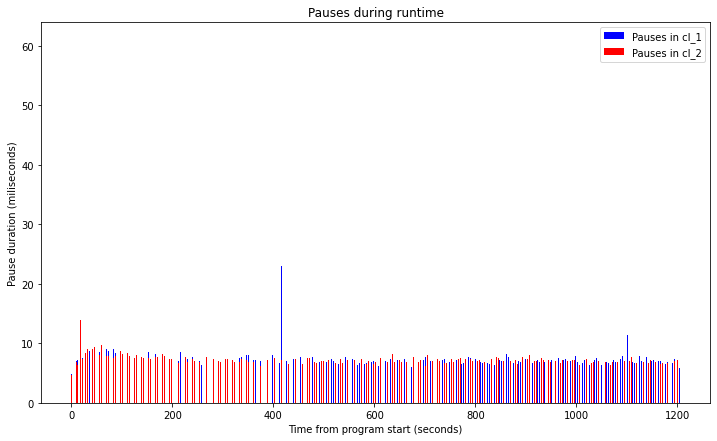

In [136]:

figure, axs = plt.subplots()

df_cl1  = upl.getPauses(logfile = "datasets/cl_1.log")
x, y    = uplt.get_combined_xy_pauses(p2_df)
uplt.plot_pauses_bar(x, y, axs, label = "Pauses in cl_1",  color = "blue")

df_cl2 = upl.getPauses(logfile = "datasets/cl_2.log")
x, y   = uplt.get_combined_xy_pauses(pauses_df)
uplt.plot_pauses_bar(x, y, axs, label = "Pauses in cl_2", color = "red")

plt.show()

Shenandoah


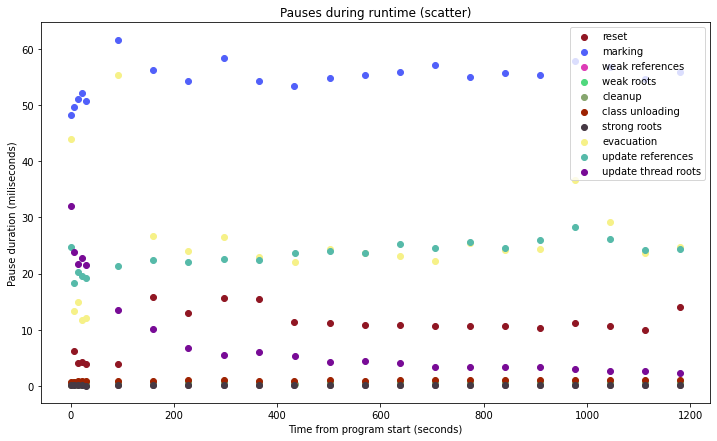

In [158]:
figure, axs = plt.subplots()
concurrent_data = upl.getConcurrentDurations("datasets/gc-many/shenandoah_log.log")


dict_mapping = {} # holds relationship between name and words

# Count how many different phase types we have
counter = 0
for phase in concurrent_data["ConcurrentPhase"]:
    if phase not in dict_mapping:
        dict_mapping[phase] = counter
        counter += 1
        
# Map everything from the phase type to the integer in the  list it represents.
cc_pause_indicies = []
for phase in concurrent_data["ConcurrentPhase"]:
    cc_pause_indicies.append(dict_mapping[phase])


# Update the pause data to use integer types
concurrent_data["PauseType"] = cc_pause_indicies
names = list([(key, dict_mapping[key]) for key in dict_mapping.keys()])
labels = [[] for i in range(len(names))]
for name in names:
    labels[name[1]] = name[0].strip()

def scatter_shenandoah(table):
    if table.empty:
        return
    # access the interesting information directly
    times = table["TimeFromStart_seconds"]
    pauses = table["PauseDuration_miliseconds"]
    types = table["PauseType"]
    
    # determine what types of pauses exist in this data
   
    numT = 0
    # determine the number of types
    for i in range(len(types)):
        numT = max(numT, types[i])
    
    pauseArray = [[[], []] for i in range(numT + 1)]

    # Arrange the data into buckets based on the pause type
    for i in range(len(types)):   
        pauseArray[types[i]][0].append(times[i])
        pauseArray[types[i]][1].append(pauses[i])
    return pauseArray

# Make sure to transform the duration from string -> float.
concurrent_data["PauseDuration_miliseconds"] = list(map(float, concurrent_data["PauseDuration_miliseconds"]))


pa=scatter_shenandoah(concurrent_data)    
for i in range(len(pa)):
    uplt.plot_pauses_scatter(pa[i][0], pa[i][1], axs, label = labels[i])
plt.show()
    
    
#dplt.plot_scatter(concurrent_data, labels = labels)
#print(cc_pause_type)
#print(concurrent_data)

### Heap allocation breakdown after GC runs


Shenandoah
4671 455 4672
4199 175 4712
4287 255 4736
4217 185 4744
4224 192 4760
13274 155 14008
13969 149 14008
13653 149 14016
13053 147 14024
12688 152 14024
12480 152 14024
12125 150 14024
11883 155 14032
11773 149 14032
11900 154 14032
11950 150 14032
11659 147 14032
12046 150 14032
11995 155 14040
11910 145 14040
12038 150 14048
11893 149 14048
length before:  22
length timestamps:  44


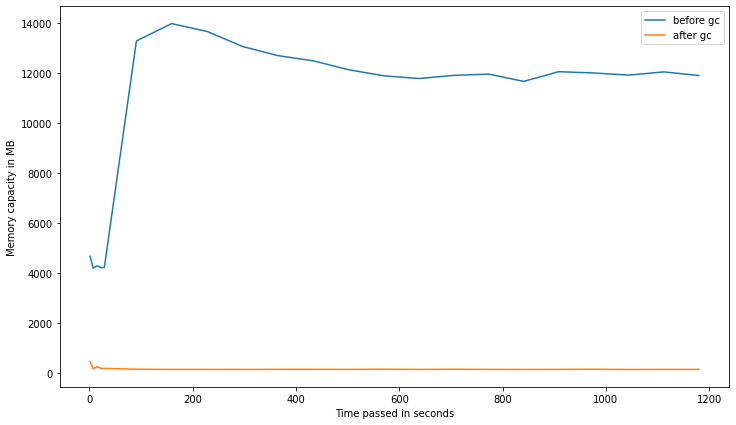

In [185]:
import re
def run():
    concurrent_data = upl.getConcurrentDurations("datasets/gc-many/shenandoah_log.log")
    #concurrent_data = upl.getConcurrentDurations("datasets/gc-many/gclog-shenandoah")

    delta = concurrent_data["AdditionalNotes"]
    times = concurrent_data["TimeFromStart_seconds"]
    timestamps_seconds = []
    change_space_str = []
    for i in range(len(delta)):
        if delta[i]:
            timestamps_seconds.append(times[i])
            change_space_str.append(delta[i])

    
    before_gc_list  = []
    after_gc_list   = []
    currmax_gc_list    = []
    
    first = True
    for line in change_space_str:
        if not first:
            before, after, currmax = extract_change(line)
            print(before, after, currmax)
            before_gc_list.append(before)
            after_gc_list.append(after)
            currmax_gc_list.append(currmax)
        first = not first
    t = []
    first = True
    for time in timestamps_seconds:
        if not first:  
            t.append(time)
        first = not first
    
    print("length before: ", len(before_gc_list))
    print("length timestamps: ", len(timestamps_seconds))
    plt.plot(t, before_gc_list, label = "before gc")
    plt.plot(t, after_gc_list, label = "after gc")
    #plt.plot(t, currmax_gc_list, label = "current max heap size")
    plt.xlabel("Time passed in seconds")
    plt.ylabel("Memory capacity in MB")
    plt.legend()
    plt.show()
    
        

def extract_change(single_change):
    regex_string = "(\d+)\w+->(\d+)\w+\((\d+)\w+\)"
    # group 1 : before
    # group 2 : after
    # group 3 : current heap size
    match = re.search(regex_string, single_change)
    
    if match:
        return int(match.group(1)), int(match.group(2)), int(match.group(3))
    else:
        print("nO MATCH AAAA")
    
run()

### Test printing percentiles and comparison scatter/bar plots

In [87]:
from scripts import updated_plot_data as uplt
from scripts import updated_parse_data as upl
from scripts import transform_data as tform
df_cl1  = upl.getPauses(logfile = "datasets/cl_1.log")
#print("Dataframe 1 from cl_1.log.\n", df_cl1.info())
df_cl2  = upl.getPauses(logfile = "datasets/cl_2.log")
#uplt.print_trends(tform.get_pauses_in_miliseconds(df_cl1))
uplt.comparison_trends([tform.get_pauses_in_miliseconds(df_cl1), tform.get_pauses_in_miliseconds(df_cl2)])
#print("\n\nDataframe 2 from cl_2.log.\ndf")
# #print(df_cl2.info())
# x1, y1 = tform.get_combined_xy_pauses(df_cl1)
# x2, y2 = tform.get_combined_xy_pauses(df_cl2)

# r = uplt.plot_comparison_scatter([x1], [y1], None, ["k"], ["dot label"])
# r = uplt.plot_bar_comparison([x1], [y1], r, ["r"], ["label"])
# r = uplt.comparison_pauses_percentiles([list(y1), list(y2)], labels = ["cl_1", "cl_2"])
# f, a = plt.subplots()
# r = uplt.plot_pauses_line(x1, y1, a, "k", "Pauses during runtime")
# r = uplt.comparison_pauses_line([x1, x2], [y1, y2], None, ["k","b"], ["One", "Two"])

 Trends       |  Total Pauses |  Max pause    |  Sum pauses   |  Mean pauses  | 
--------------------------------------------------------------------------------
0             | 354           | 60.926        | 2657.824      | 7.508         | 
1             | 354           | 59.952        | 2651.998      | 7.4915        | 


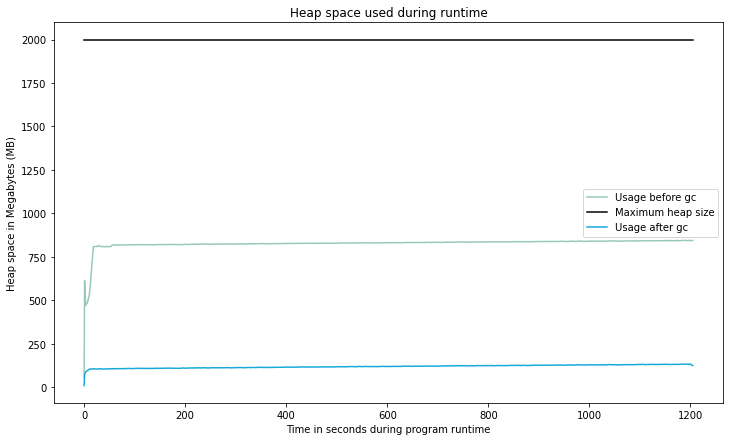

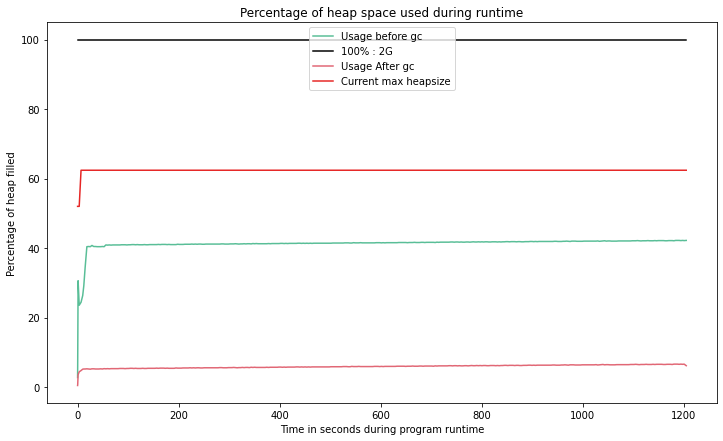

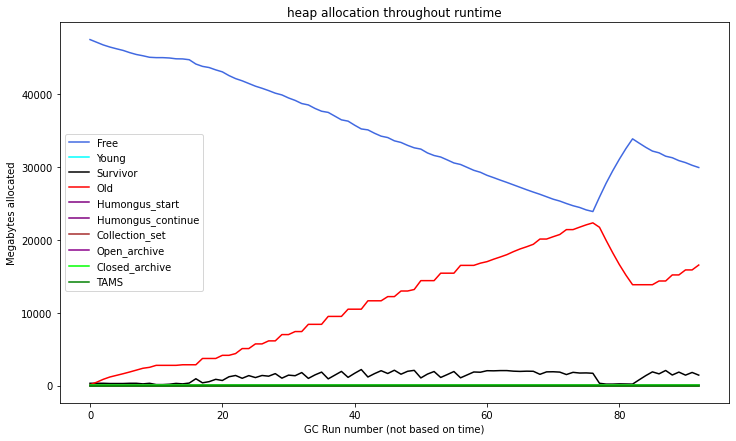

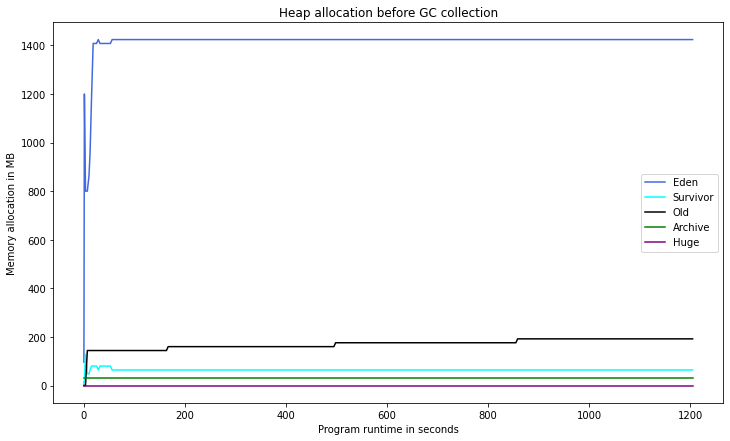

In [162]:
from scripts import updated_plot_data as uplt
from scripts import updated_parse_data as upl
from scripts import transform_data as tfrom
from scripts import make_heatmap as mh # long file. Consider removing extra code.
path1 = "datasets/cl_1.log"
path2 = "datasets/cl_3.log"
path3 = "datasets/cl_2.log"
d1     = upl.getPauses(logfile = path1)
d2     = upl.getPauses(logfile = path2)
d3     = upl.getPauses(logfile = path3)
m1 = upl.getGCMetadata(path1)
m2 = upl.getGCMetadata(path2)
m3 = upl.getGCMetadata(path3)
x1, y1 = tfrom.get_combined_xy_pauses(d1)
x2, y2 = tfrom.get_combined_xy_pauses(d2)
x3, y3 = tfrom.get_combined_xy_pauses(d3)
labels = ["Run 1", "Run 2", "Run 3"]
colors = ["r", "b", "k"]
color  = "black"
label  = "First run"
times  = [x1, x2, x3]
pauses = [y1, y2, y3]
#####################

line_graph  = False   # tested. working
bar_graph   = False   # tested. working
sum_bars    = False   # tested. Working
max_bars    = False   # tested. Working
percentiles = False   # tested. Working
trends      = False   # tested. Working
metadata    = False   # tested. Working
heatmap     = False   # tested. Working
scatter     = False   # tested. Working
allocation  = False   # tested. Working
line_run    = False   # tested. Working

#######
# line graph
############################################################
if line_graph:
    f, axs = plt.subplots()
    _ = uplt.plot_pauses_line(x1, y1, axs, color, label)
    _ = uplt.compare_pauses_line(times, pauses, None, colors, labels)

############################################################
if bar_graph:
    f, axs = plt.subplots()
    _ = uplt.plot_pauses_bar(x1, y1, axs, color, label)
    _ = uplt.compare_pauses_bar(times, pauses, None, colors, labels)

############################################################
if percentiles:
    uplt.print_percentiles(list(y1))
    print("\n\n")
    uplt.print_percentiles(list(y1), percentiles = [50, 75, 99.9999])
    print("\n\n")
    uplt.compare_pauses_percentiles(list(pauses), labels=labels)

############################################################
if trends:
    uplt.print_trends(y1)
    print("\n\n") 
    uplt.compare_pauses_percentiles(list(pauses), labels=labels)

############################################################
if heatmap:
    hm, dimensions = tfrom.get_heatmap_data(d1, x_bucket_count = 20, y_bucket_count = 20, x_bucket_duration = 60, y_bucket_duration = 2)
    uplt.plot_heatmap(hm, dimensions, True)
    uplt.plot_heatmap(hm, dimensions, False)
    
############################################################
if line_run:
    f, axs = plt.subplots()
    _ = uplt.plot_paused_and_running_line(x1, y1, axs, color, label)
    uplt.compare_paused_running_line(times, pauses, None, colors, labels)
    
############################################################   
if sum_bars:
    f, axs = plt.subplots()
    timedata, bucketdata = tfrom.get_sum_pauses_n_duration(x1, y1, 10)
    _ = uplt.plot_paused_and_running_line(timedata, bucketdata, axs, color, label, True)
    timelist, bucketlist = tfrom.compare_sum_pauses_n_buckets(times, pauses, 8)
    _ = uplt.compare_paused_running_line(timelist, bucketlist, None, colors, labels, const_bar_width = True)
    timelist, bucketlist = tfrom.compare_max_pauses_n_duration(times, pauses, 10)
    _ = uplt.compare_paused_running_line(timelist, bucketlist, None, colors, labels, const_bar_width = True)

############################################################
if metadata:
    uplt.print_metadata_short(m1)
    print("\n\n\n")
    uplt.print_metadata([m1, m2, m3], labels, 20)

############################################################
if scatter:
    fix, axs = plt.subplots()
    uplt.plot_pauses_scatter(x1, y1, axs, "Red", "Hello World!")
    _ = uplt.comparrison_scatter(times, pauses, None, colors, labels)
    
############################################################
if allocation:
    before_gc, after_gc, max_heap, unit = tfrom.get_heap_occupancy(d1)
    graph = pha.plot_heap_occupancy(x1, before_gc, unit, 2, "G", label = "Usage before gc")
    _ = pha.plot_heap_occupancy(x1, after_gc, unit, 2, "G", axs = graph, label = "Usage after gc", plot_max=False)
    graph = None
    graph = pha.plot_heap_occupancy_percentage(x1, before_gc, unit, 2, "G", label = "Usage before gc")
    graph = pha.plot_heap_occupancy_percentage(x1, after_gc, unit, 2, "G", label = "Usage After gc", axs = graph, plot_max = False)
    graph = pha.plot_heap_occupancy_percentage(x1, max_heap, unit, 2, "G", label = "Current max heapsize", axs = graph, plot_max = False)
    allo = upl.getHeapAllocation(path1)
    allo2 = upl.getHeapAllocation("datasets/gc.log", robust = True)
    _ = pha.plot_heap_regions(allo2, region_size = 16) # tested, working
    _ = pha.plot_heap_regions(allo, region_size = 16)  # tested, working
    
    
